start constructing dataset
train 38 tensor([34.]) tensor([1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
        0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.]) /home/disk/disk4/AwA2/Animals_with_Attributes2/JPEGImages/weasel/weasel_10134.jpg
val 38 tensor([17.]) tensor([1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.]) /home/disk/disk4/AwA2/Animals_with_Attributes2/JPEGImages/humpback+whale/humpback+wha

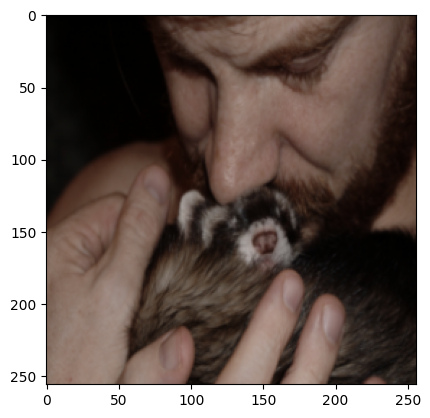

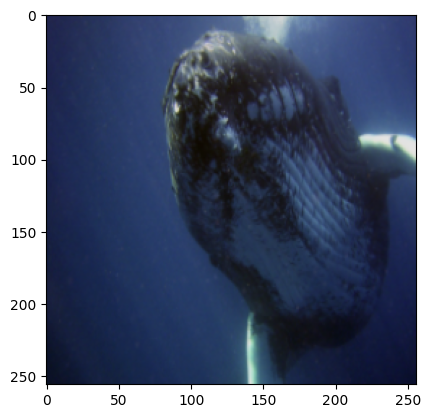

In [1]:
from models.SECBM import SemanticCBM
from sklearn.manifold import TSNE
import argparse
from dataloaders import awa2_dataloader
from models.SECBM import SemanticCBM
from models.baseline_models import *
import torch
import os
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
# from pytorch_lightning import seed_everything

# dataloader
parser = argparse.ArgumentParser(description='manual to this script')
parser.add_argument("--dataroot", type=str, default='/home/disk/disk4/AwA2/Animals_with_Attributes2')
parser.add_argument("--batch-size", type=int, default=128)
parser.add_argument("--img-size", type=int, default=256)
parser.add_argument('--workers', type=int, default=8)
parser.add_argument('--USE_IMAGENET_INCEPTION', type=bool, default=True)
parser.add_argument('--train-val-test-ratio', type=list, default=[0.6, 0.1, 0.3])
parser.add_argument('--used-group', type=list, default=None)
parser.add_argument('--normalized', type=bool, default=False)

parser.add_argument('--device', type=str, default='cuda:2')
args = parser.parse_args(args=[])

dataloaders, class2index, concept2index, attr_group_dict, group_size = awa2_dataloader.load_data(args)
print(f'concept groups: {attr_group_dict}')# , attr_group_dict)
print(f'group size: {group_size}')

channel = 12
emb_dim = 32
n_classes = 50
# nonlinear = False
device = torch.device(args.device if torch.cuda.is_available() else 'cpu')


In [73]:
from models.SECBM import SemanticCBM
model_path = os.path.join('./FinalCheckpoints_0714/AwA2/12_32/ViP-CEM-anchor/Seed_3407', '224.pth')
model = SemanticCBM(8, channel, emb_dim, attr_group_dict, device, 'joint', n_classes, nonlinear=True, use_group=True, use_emb=True, use_logits=True, anchor_model=2, shift='none', explaining=True).to(device)
model.load_state_dict(torch.load(model_path))
# train
model.eval()

unl_list = []
ulp_list = []
z_list = []
y_list = []
c_list = []
for samples in tqdm(dataloaders['test']):
    images, labels, concepts = samples['image'], samples['class_label'], samples['concept_label']
    x, y, c = images.to(device), labels.to(device).squeeze().type(torch.long), concepts.to(device)
    z, u_nl, u_lp = model(x, c)# .detach().cpu().numpy() # (N, K, m)
    c_list.append(c.detach().cpu().numpy())
    z_list.append(z.detach().cpu().numpy())
    unl_list.append(u_nl.detach().cpu().numpy())
    ulp_list.append(u_lp.detach().cpu().numpy())
    y_list.append(y.detach().cpu().numpy())

u_nl = np.concatenate(unl_list, 0)
u_lp = np.concatenate(ulp_list, 0)
z = np.concatenate(z_list, 0)
c = np.concatenate(c_list, 0)
y = np.concatenate(y_list, 0)

print(class2index, concept2index)

100%|██████████| 88/88 [01:45<00:00,  1.20s/it]


{'antelope': 0, 'grizzly+bear': 1, 'killer+whale': 2, 'beaver': 3, 'dalmatian': 4, 'persian+cat': 5, 'horse': 6, 'german+shepherd': 7, 'blue+whale': 8, 'siamese+cat': 9, 'skunk': 10, 'mole': 11, 'tiger': 12, 'hippopotamus': 13, 'leopard': 14, 'moose': 15, 'spider+monkey': 16, 'humpback+whale': 17, 'elephant': 18, 'gorilla': 19, 'ox': 20, 'fox': 21, 'sheep': 22, 'seal': 23, 'chimpanzee': 24, 'hamster': 25, 'squirrel': 26, 'rhinoceros': 27, 'rabbit': 28, 'bat': 29, 'giraffe': 30, 'wolf': 31, 'chihuahua': 32, 'rat': 33, 'weasel': 34, 'otter': 35, 'buffalo': 36, 'zebra': 37, 'giant+panda': 38, 'deer': 39, 'bobcat': 40, 'pig': 41, 'lion': 42, 'mouse': 43, 'polar+bear': 44, 'collie': 45, 'walrus': 46, 'raccoon': 47, 'cow': 48, 'dolphin': 49} {'black': 0, 'white': 1, 'blue': 2, 'brown': 3, 'gray': 4, 'orange': 5, 'red': 6, 'yellow': 7, 'patches': 8, 'spots': 9, 'stripes': 10, 'furry': 11, 'hairless': 12, 'toughskin': 13, 'big': 14, 'small': 15, 'bulbous': 16, 'lean': 17, 'flippers': 18, 'hand

(11197, 32, 12)
(392,) (285,)
(392, 3, 12) (285, 3, 12)
(677, 2)


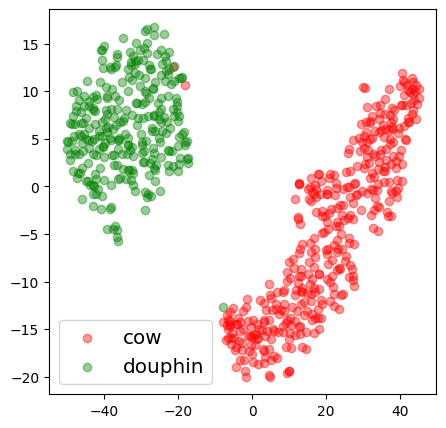

In [74]:
print(z.shape)
classes = [48, 49] # cow, dophin
concepts = [0, 1, 2] # black, white, blue
# embeddings with cow and dophin
y_cow = np.argwhere(y==48)[:,0]
y_dophin = np.argwhere(y==49)[:,0]
print(y_cow.shape, y_dophin.shape)

# u_cow = u[y_cow,0:3,:]
# u_dophin = u[y_dophin,0:3,:]
z_cow = z[y_cow,0:3,:]
z_dophin = z[y_dophin,0:3,:]
print(z_cow.shape, z_dophin.shape)
n_c, n_d = z_cow.shape[0], z_dophin.shape[0]
z_cow = z_cow.reshape(n_c, -1)
z_dophin = z_dophin.reshape(n_d, -1)
z = np.concatenate([z_cow, z_dophin], 0)
X_tsne = TSNE(n_components=2,random_state=33).fit_transform(z)
print(X_tsne.shape)
colors = ['r', 'g']
img_dir = "SE-CBM-group"
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.scatter(X_tsne[0:n_c,0], X_tsne[0:n_c,1], c='r', label='cow', alpha=0.4)
plt.scatter(X_tsne[n_c:,0], X_tsne[n_c:,1], c='g', label='douphin', alpha=0.4)
plt.legend(fontsize='x-large')
os.makedirs('visualization/ViP-CEM-anchor', exist_ok=True)
plt.savefig('visualization/digits_tsne_Z.pdf')

In [75]:
anchors = model.concept_prediction.anchors
u_cow = u_nl[y_cow,0:3,:]
u_dophin = u_nl[y_dophin,0:3,:]
n_c, n_d = u_cow.shape[0], u_dophin.shape[0]

uc = u_cow.transpose(1,0,2).reshape(-1, 12)
ud = u_dophin.transpose(1,0,2).reshape(-1, 12)
lc = np.array([0,1,2]).repeat(n_c)
ld = np.array([3, 4, 5]).repeat(n_d)
u_emb = np.concatenate([uc, ud], 0)
l_emb = np.concatenate([lc, ld], 0)
print(u_emb, l_emb)
print(u_cow[0,0],  u_cow[1,0])

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.9772657  0.33947062 0.         ... 0.         0.         0.        ]
 [0.         0.17045172 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.16485685 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.6275418  0.         ... 0.7625786  0.25622874 0.        ]] [0 0 0 ... 5 5 5]
[0.         0.         0.         0.18692386 0.         0.
 0.         3.547358   1.4945055  0.         0.         0.        ] [0.9772657  0.33947062 0.         0.10281834 0.         0.5027228
 0.         1.5805669  0.12274139 0.         0.         0.        ]


In [76]:
anchors = anchors.detach().cpu().numpy()
print(u_emb.shape, anchors.shape)
n = 100  # number of sample points
anchor1, anchor2 = anchors
midpoint = (anchor1 + anchor2) / 2
normal_vector = anchor2 - anchor1
normal_vector /= np.linalg.norm(normal_vector)

# Generate n sample points on the perpendicular bisector plane
samples = np.array([midpoint + t * normal_vector for t in np.linspace(-1, 1, n)])
print(samples.shape)

(2031, 12) (2, 12)
(100, 12)


In [77]:
with torch.cuda.device(args.device):
    torch.cuda.empty_cache()

In [78]:
tsne = TSNE(n_components=2, random_state=33)
X_tsne = tsne.fit_transform(np.concatenate((anchors, u_emb), axis=0))
print(X_tsne.shape)
anchors_tsne = X_tsne[:2]
# samples_tsne = X_tsn# e[2:n+2]
X_tsne = X_tsne[2:]
colors = ['r', 'g', 'b', 'grey', 'm', 'y']
labels = ['black', 'white', 'blue']
img_dir = "SE-CBM-group"

(2033, 2)


1176 1461
1461 1746
1746 2031


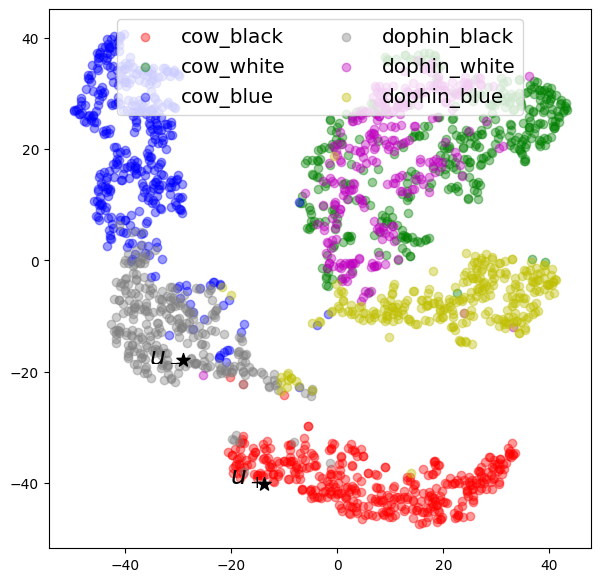

In [80]:
import matplotlib.pyplot as plt
plt.figure(figsize=[7,7])
#plt.xlim((-60,60))
#plt.ylim((-75,45))


# Sort samples_tsne along the 0th dimension
# samples_tsne_sorted = samples_tsne[np.argsort(samples_tsne[:, 0])]

# Filter points to keep only those between -60 and 60 in the 0th dimension
# samples_tsne_filtered = samples_tsne_sorted[(samples_tsne_sorted[:, 0] >= -60) & (samples_tsne_sorted[:, 0] <= 60)]

# plt.plot(samples_tsne_filtered[:, 0], samples_tsne_filtered[:, 1], c='b', linestyle='-')

for i in range(3):
    plt.scatter(X_tsne[i*n_c: (i+1) * n_c, 0], X_tsne[i*n_c: (i+1) * n_c, 1], c=colors[i], label="cow_" + labels[i], alpha=0.4)
for i in range(3):
    print(3 * n_c + i*n_d, 3* n_c + (i+1) * n_d)
    plt.scatter(X_tsne[3 * n_c + i*n_d: 3* n_c + (i+1) * n_d, 0], X_tsne[3 * n_c + i*n_d: 3* n_c + (i+1) * n_d, 1], c=colors[i+3], label="dophin_" + labels[i], alpha=0.4)
plt.legend(ncol=2, loc='upper center', fontsize='x-large')

plt.scatter(anchors_tsne[0,0], anchors_tsne[0,1], marker='*', color='k', s=100)
plt.text(anchors_tsne[0,0], anchors_tsne[0,1], r'$u_-$', fontsize=18, ha='right')
plt.scatter(anchors_tsne[1,0], anchors_tsne[1,1], marker='*', color='k', s=100)
plt.text(anchors_tsne[1,0], anchors_tsne[1,1], r'$u_+$', fontsize=18, ha='right')
plt.savefig('visualization/ViP-CEM-anchor/digits_tsne_NLP.pdf')

In [81]:
from models.SECBM import SemanticCBM
model_path = os.path.join('./FinalCheckpoints_0714/AwA2/12_32/ViP-CEM-anchor-LP/Seed_42', '224.pth')
model = SemanticCBM(8, channel, emb_dim, attr_group_dict, device, 'joint', n_classes, nonlinear=False, use_group=True, use_emb=True, use_logits=True, anchor_model=0, shift='none', explaining=True).to(device)
model.load_state_dict(torch.load(model_path))
# train
model.eval()

unl_list = []
ulp_list = []
z_list = []
y_list = []
c_list = []
for samples in tqdm(dataloaders['test']):
    images, labels, concepts = samples['image'], samples['class_label'], samples['concept_label']
    x, y, c = images.to(device), labels.to(device).squeeze().type(torch.long), concepts.to(device)
    z, u_nl, u_lp = model(x, c)# .detach().cpu().numpy() # (N, K, m)
    c_list.append(c.detach().cpu().numpy())
    z_list.append(z.detach().cpu().numpy())
    unl_list.append(u_nl.detach().cpu().numpy())
    ulp_list.append(u_lp.detach().cpu().numpy())
    y_list.append(y.detach().cpu().numpy())

u_nl = np.concatenate(unl_list, 0)
u_lp = np.concatenate(ulp_list, 0)
z = np.concatenate(z_list, 0)
c = np.concatenate(c_list, 0)
y = np.concatenate(y_list, 0)

print(class2index, concept2index)

100%|██████████| 88/88 [01:02<00:00,  1.42it/s]

{'antelope': 0, 'grizzly+bear': 1, 'killer+whale': 2, 'beaver': 3, 'dalmatian': 4, 'persian+cat': 5, 'horse': 6, 'german+shepherd': 7, 'blue+whale': 8, 'siamese+cat': 9, 'skunk': 10, 'mole': 11, 'tiger': 12, 'hippopotamus': 13, 'leopard': 14, 'moose': 15, 'spider+monkey': 16, 'humpback+whale': 17, 'elephant': 18, 'gorilla': 19, 'ox': 20, 'fox': 21, 'sheep': 22, 'seal': 23, 'chimpanzee': 24, 'hamster': 25, 'squirrel': 26, 'rhinoceros': 27, 'rabbit': 28, 'bat': 29, 'giraffe': 30, 'wolf': 31, 'chihuahua': 32, 'rat': 33, 'weasel': 34, 'otter': 35, 'buffalo': 36, 'zebra': 37, 'giant+panda': 38, 'deer': 39, 'bobcat': 40, 'pig': 41, 'lion': 42, 'mouse': 43, 'polar+bear': 44, 'collie': 45, 'walrus': 46, 'raccoon': 47, 'cow': 48, 'dolphin': 49} {'black': 0, 'white': 1, 'blue': 2, 'brown': 3, 'gray': 4, 'orange': 5, 'red': 6, 'yellow': 7, 'patches': 8, 'spots': 9, 'stripes': 10, 'furry': 11, 'hairless': 12, 'toughskin': 13, 'big': 14, 'small': 15, 'bulbous': 16, 'lean': 17, 'flippers': 18, 'hand

(11197, 32, 12)
(392,) (285,)
(392, 3, 12) (285, 3, 12)
(677, 2)


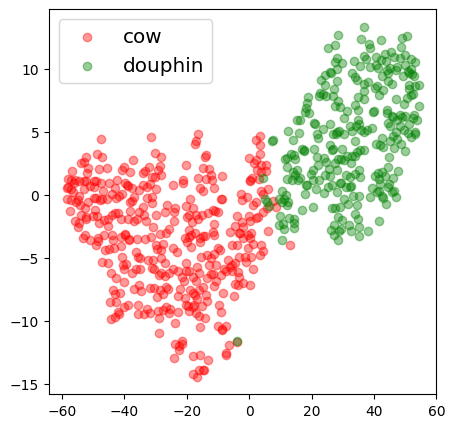

In [82]:
print(z.shape)
classes = [48, 49] # cow, dophin
concepts = [0, 1, 2] # black, white, blue
# embeddings with cow and dophin
y_cow = np.argwhere(y==48)[:,0]
y_dophin = np.argwhere(y==49)[:,0]
print(y_cow.shape, y_dophin.shape)

# u_cow = u[y_cow,0:3,:]
# u_dophin = u[y_dophin,0:3,:]
z_cow = z[y_cow,0:3,:]
z_dophin = z[y_dophin,0:3,:]
print(z_cow.shape, z_dophin.shape)
n_c, n_d = z_cow.shape[0], z_dophin.shape[0]
z_cow = z_cow.reshape(n_c, -1)
z_dophin = z_dophin.reshape(n_d, -1)
z = np.concatenate([z_cow, z_dophin], 0)
X_tsne = TSNE(n_components=2,random_state=33).fit_transform(z)
print(X_tsne.shape)
colors = ['r', 'g']
img_dir = "SE-CBM-group"
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.scatter(X_tsne[0:n_c,0], X_tsne[0:n_c,1], c='r', label='cow', alpha=0.4)
plt.scatter(X_tsne[n_c:,0], X_tsne[n_c:,1], c='g', label='douphin', alpha=0.4)
plt.legend(fontsize='x-large')
os.makedirs('visualization/ViP-CEM-anchor-LP', exist_ok=True)
plt.savefig('visualization/ViP-CEM-anchor-LP/digits_tsne_Z.pdf')

In [83]:
# anchors = model.concept_prediction.anchors
u_cow = u_nl[y_cow,0:3,:]
u_dophin = u_nl[y_dophin,0:3,:]
n_c, n_d = u_cow.shape[0], u_dophin.shape[0]

uc = u_cow.transpose(1,0,2).reshape(-1, 12)
ud = u_dophin.transpose(1,0,2).reshape(-1, 12)
lc = np.array([0,1,2]).repeat(n_c)
ld = np.array([3, 4, 5]).repeat(n_d)
u_emb = np.concatenate([uc, ud], 0)
l_emb = np.concatenate([lc, ld], 0)
print(u_emb, l_emb)
print(u_cow[0,0],  u_cow[1,0])

[[-1.402618    2.326014    3.5042896  ... -1.3427887  -1.5117302
   0.4366697 ]
 [-1.1327897   2.5336556   3.7191834  ... -0.49827528 -1.2470533
  -0.5756172 ]
 [-1.3054947   1.1332      0.601929   ... -0.5819652  -0.22751465
  -0.38397175]
 ...
 [-1.0756719   1.5009291   3.2598476  ... -1.2924407  -1.6557982
   0.4416994 ]
 [-0.90926665  1.4030217  -0.6282333  ...  0.34839693 -0.23698744
  -1.168887  ]
 [-1.6519202   2.029777    2.6303253  ... -1.0622687  -1.2179115
  -0.5040765 ]] [0 0 0 ... 5 5 5]
[-1.402618    2.326014    3.5042896  -1.4429276  -0.14599776 -0.0604142
 -2.1557765   0.99842095 -0.00525499 -1.3427887  -1.5117302   0.4366697 ] [-1.1327897   2.5336556   3.7191834  -2.1535192   0.4159236  -0.540339
 -1.7088573   1.410289   -0.60689217 -0.49827528 -1.2470533  -0.5756172 ]


In [84]:
print(u_emb.shape)

(2031, 12)


(2031, 2)
1176 1461
1461 1746
1746 2031


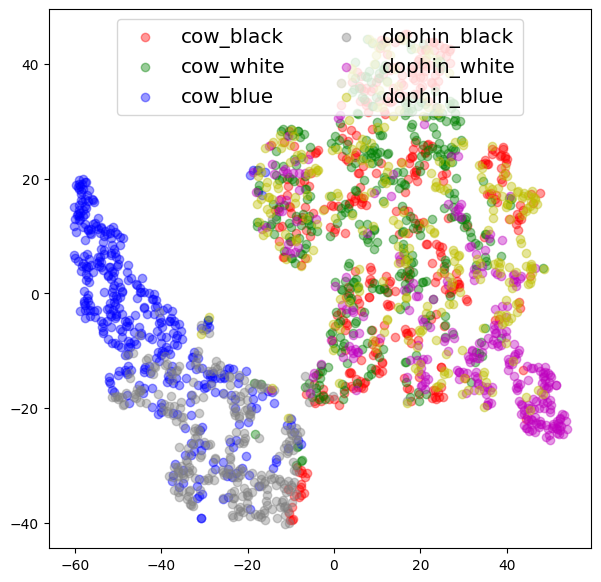

In [85]:
tsne = TSNE(n_components=2, random_state=33)
X_tsne = tsne.fit_transform(u_emb)
print(X_tsne.shape)

colors = ['r', 'g', 'b', 'grey', 'm', 'y']
labels = ['black', 'white', 'blue']
img_dir = "SE-CBM-group"
import matplotlib.pyplot as plt
plt.figure(figsize=[7,7])
#plt.xlim((-60,60))
#plt.ylim((-75,45))

# Sort samples_tsne along the 0th dimension
# samples_tsne_sorted = samples_tsne[np.argsort(samples_tsne[:, 0])]

# Filter points to keep only those between -60 and 60 in the 0th dimension
# samples_tsne_filtered = samples_tsne_sorted[(samples_tsne_sorted[:, 0] >= -60) & (samples_tsne_sorted[:, 0] <= 60)]

# plt.plot(samples_tsne_filtered[:, 0], samples_tsne_filtered[:, 1], c='b', linestyle='-')

for i in range(3):
    plt.scatter(X_tsne[i*n_c: (i+1) * n_c, 0], X_tsne[i*n_c: (i+1) * n_c, 1], c=colors[i], label="cow_" + labels[i], alpha=0.4)
for i in range(3):
    print(3 * n_c + i*n_d, 3* n_c + (i+1) * n_d)
    plt.scatter(X_tsne[3 * n_c + i*n_d: 3* n_c + (i+1) * n_d, 0], X_tsne[3 * n_c + i*n_d: 3* n_c + (i+1) * n_d, 1], c=colors[i+3], label="dophin_" + labels[i], alpha=0.4)
plt.legend(ncol=2, loc='upper center', fontsize='x-large')
plt.savefig('visualization/ViP-CEM-anchor-LP/digits_tsne_NLP.pdf')

# Baselines

In [36]:
with torch.cuda.device(args.device):
    torch.cuda.empty_cache()

Seed set to 3407


start constructing dataset
train 7 tensor([13.]) tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.]) /home/disk/disk4/AwA2/Animals_with_Attributes2/JPEGImages/hippopotamus/hippopotamus_10163.jpg
val 7 tensor([30.]) tensor([0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]) /home/disk/disk4/AwA2/Animals_with_Attributes2/JPEGImages/giraffe/giraffe_1

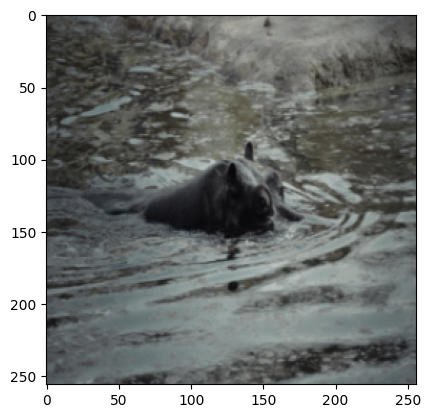

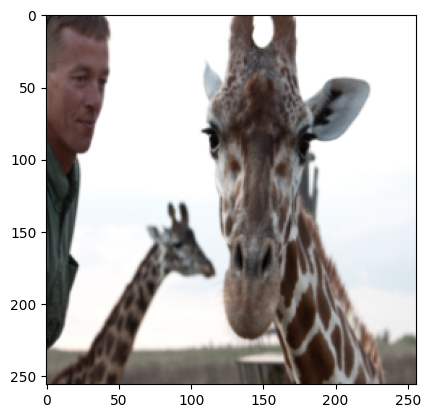

In [57]:
from models.SECBM import SemanticCBM
from sklearn.manifold import TSNE
import argparse
from dataloaders import awa2_dataloader
from models.SECBM import SemanticCBM
from models.baseline_models import *
import torch
import os
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
from pytorch_lightning import seed_everything

seed_everything(3407)

# dataloader
parser = argparse.ArgumentParser(description='manual to this script')
parser.add_argument("--dataroot", type=str, default='/home/disk/disk4/AwA2/Animals_with_Attributes2')
parser.add_argument("--batch-size", type=int, default=128)
parser.add_argument("--img-size", type=int, default=256)
parser.add_argument('--workers', type=int, default=8)
parser.add_argument('--USE_IMAGENET_INCEPTION', type=bool, default=True)
parser.add_argument('--train-val-test-ratio', type=list, default=[0.6, 0.1, 0.3])
parser.add_argument('--used-group', type=list, default=None)
parser.add_argument('--normalized', type=bool, default=False)

parser.add_argument('--device', type=str, default='cuda:2')
args = parser.parse_args(args=[])

dataloaders, class2index, concept2index, attr_group_dict, group_size = awa2_dataloader.load_data(args)
print(f'concept groups: {attr_group_dict}')# , attr_group_dict)
print(f'group size: {group_size}')

channel = 12
emb_dim = 32
n_classes = 50
# nonlinear = False
device = torch.device(args.device if torch.cuda.is_available() else 'cpu')


In [58]:
from models.baseline_models import ProbCBM

model_path = os.path.join('./FinalCheckpoints_0714/AwA2/12_32/ProbCBM/Seed_3407', '224.pth')
backbone_dim = 8
n_concepts = 85
model = ProbCBM(backbone_dim, n_classes, n_concepts, emb_dim, device, use_sigmoid=False, explain=True).to(device)
model.load_state_dict(torch.load(model_path))
# train
model.eval()

unl_list = []
ulp_list = []
z_list = []
y_list = []
c_list = []
for samples in tqdm(dataloaders['test']):
    images, labels, concepts = samples['image'], samples['class_label'], samples['concept_label']
    x, y, c = images.to(device), labels.to(device).squeeze().type(torch.long), concepts.to(device)
    with torch.no_grad():
        z = model(x, c)# .detach().cpu().numpy() # (N, K, m)
    c_list.append(c.detach().cpu().numpy())
    z_list.append(z.detach().cpu().numpy())
    y_list.append(y.detach().cpu().numpy())

z = np.concatenate(z_list, 0)
c = np.concatenate(c_list, 0)
y = np.concatenate(y_list, 0)

print(class2index, concept2index)

100%|██████████| 88/88 [01:35<00:00,  1.08s/it]

{'antelope': 0, 'grizzly+bear': 1, 'killer+whale': 2, 'beaver': 3, 'dalmatian': 4, 'persian+cat': 5, 'horse': 6, 'german+shepherd': 7, 'blue+whale': 8, 'siamese+cat': 9, 'skunk': 10, 'mole': 11, 'tiger': 12, 'hippopotamus': 13, 'leopard': 14, 'moose': 15, 'spider+monkey': 16, 'humpback+whale': 17, 'elephant': 18, 'gorilla': 19, 'ox': 20, 'fox': 21, 'sheep': 22, 'seal': 23, 'chimpanzee': 24, 'hamster': 25, 'squirrel': 26, 'rhinoceros': 27, 'rabbit': 28, 'bat': 29, 'giraffe': 30, 'wolf': 31, 'chihuahua': 32, 'rat': 33, 'weasel': 34, 'otter': 35, 'buffalo': 36, 'zebra': 37, 'giant+panda': 38, 'deer': 39, 'bobcat': 40, 'pig': 41, 'lion': 42, 'mouse': 43, 'polar+bear': 44, 'collie': 45, 'walrus': 46, 'raccoon': 47, 'cow': 48, 'dolphin': 49} {'black': 0, 'white': 1, 'blue': 2, 'brown': 3, 'gray': 4, 'orange': 5, 'red': 6, 'yellow': 7, 'patches': 8, 'spots': 9, 'stripes': 10, 'furry': 11, 'hairless': 12, 'toughskin': 13, 'big': 14, 'small': 15, 'bulbous': 16, 'lean': 17, 'flippers': 18, 'hand

In [59]:
c_p = model.pos_embeddings(torch.LongTensor(range(model.n_concepts)).to(model.device)) # in (N, n_concepts, emb_dim)
c_n = model.neg_embeddings(torch.LongTensor(range(model.n_concepts)).to(model.device))

c_p = c_p.detach().cpu().numpy()
c_n = c_n.detach().cpu().numpy()
print(c_p.shape, c_n.shape)
print(z.shape)

(85, 32) (85, 32)
(11197, 85, 32)


(11197, 85, 32)
(392,) (285,)
(392, 3, 32) (285, 3, 32)
(677, 2)


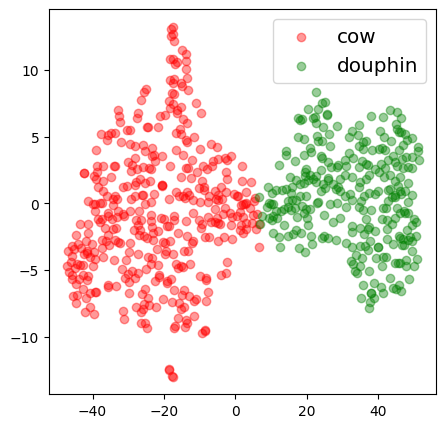

In [60]:
print(z.shape)
classes = [48, 49] # cow, dophin
concepts = [0, 1, 2] # black, white, blue
# embeddings with cow and dophin
y_cow = np.argwhere(y==48)[:,0]
y_dophin = np.argwhere(y==49)[:,0]
print(y_cow.shape, y_dophin.shape)

# u_cow = u[y_cow,0:3,:]
# u_dophin = u[y_dophin,0:3,:]
z_cow = z[y_cow,0:3,:]
z_dophin = z[y_dophin,0:3,:]
print(z_cow.shape, z_dophin.shape)
n_c, n_d = z_cow.shape[0], z_dophin.shape[0]
z_cow = z_cow.reshape(n_c, -1)
z_dophin = z_dophin.reshape(n_d, -1)
z_all = np.concatenate([z_cow, z_dophin], 0)

X_tsne = TSNE(n_components=2,random_state=33).fit_transform(z_all)
print(X_tsne.shape)
colors = ['r', 'g']
img_dir = "SE-CBM-group"
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.scatter(X_tsne[0:n_c,0], X_tsne[0:n_c,1], c='r', label='cow', alpha=0.4)
plt.scatter(X_tsne[n_c:,0], X_tsne[n_c:,1], c='g', label='douphin', alpha=0.4)
plt.legend(fontsize='x-large')
os.makedirs('visualization/ViP-CEM-anchor-LP', exist_ok=True)
plt.savefig('visualization/ProbCBM/digits_tsne_Z.pdf')

In [61]:
u_cow = z[y_cow,0:3,:]
u_dophin = z[y_dophin,0:3,:]
n_c, n_d = u_cow.shape[0], u_dophin.shape[0]
print(u_cow.shape)

uc = u_cow.transpose(1,0,2).reshape(-1, 32)
ud = u_dophin.transpose(1,0,2).reshape(-1, 32)
print(uc.shape)
lc = np.array([0,1,2]).repeat(n_c)
ld = np.array([3, 4, 5]).repeat(n_d)
u_emb = np.concatenate([uc, ud], 0)
l_emb = np.concatenate([lc, ld], 0)
print(u_emb, l_emb)
print(u_cow[0,0],  u_cow[1,0])

(392, 3, 32)
(1176, 32)
[[-1.4776447  -0.8072046  -1.341946   ... -1.121915    1.996195
   0.5159731 ]
 [-1.0630659  -0.77757007 -0.89571095 ... -0.73529965  1.8796419
   0.8100342 ]
 [-1.264366   -0.7388955  -0.7161567  ... -1.0675706   0.8604552
   0.6121781 ]
 ...
 [ 0.08705166 -1.8322573   2.0098925  ... -0.05937818 -0.42479086
  -1.9652052 ]
 [-0.43937325 -0.61363673  0.48372504 ... -0.4695636  -0.36511117
  -0.62111956]
 [-0.5521748  -0.14236815  0.23008938 ... -0.8236119  -0.45993313
  -0.6513854 ]] [0 0 0 ... 5 5 5]
[-1.4776447e+00 -8.0720460e-01 -1.3419460e+00  1.5232971e-01
 -1.5719543e+00  1.4230629e+00 -9.5191759e-01 -2.7487445e-01
  2.1853647e-01 -1.2723272e+00  4.2395175e-01 -1.4434892e+00
  2.5596943e+00 -9.3427736e-01 -4.0958047e-01 -2.3153259e-01
 -2.6909295e-01  5.3049159e-01  7.6899886e-01 -2.1264143e-03
  5.3235966e-01 -1.0857501e+00 -4.8907736e-01 -2.0475435e+00
  1.2076179e+00 -4.2688232e-02 -2.3543428e-01 -1.4098603e+00
 -1.0720569e+00 -1.1219150e+00  1.9961950e+

(2037, 2)
1176 1461
1461 1746
1746 2031


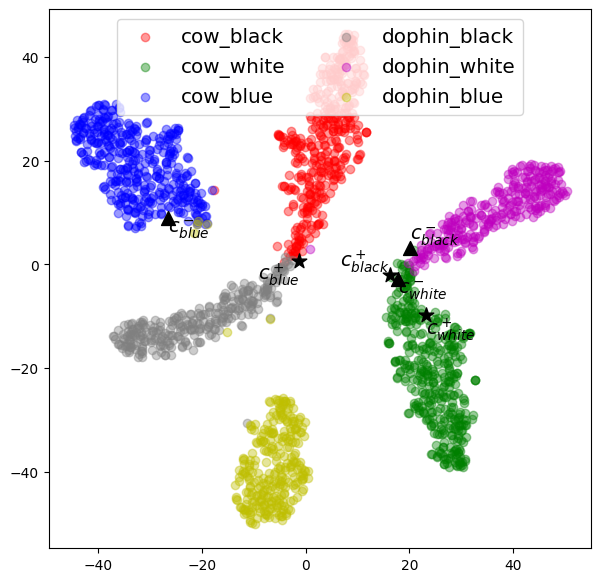

In [67]:
tsne = TSNE(n_components=2, random_state=33)
X_tsne = tsne.fit_transform(np.concatenate((c_p[0:3], c_n[0:3], u_emb), axis=0))
print(X_tsne.shape)

c_p_tsne = X_tsne[:3]
c_n_tsne = X_tsne[3:6]
X_tsne = X_tsne[6:]

colors = ['r', 'g', 'b', 'grey', 'm', 'y']
labels = ['black', 'white', 'blue']
img_dir = "SE-CBM-group"
import matplotlib.pyplot as plt
plt.figure(figsize=[7,7])
#plt.xlim((-60,60))
#plt.ylim((-75,45))

# Sort samples_tsne along the 0th dimension
# samples_tsne_sorted = samples_tsne[np.argsort(samples_tsne[:, 0])]

# Filter points to keep only those between -60 and 60 in the 0th dimension
# samples_tsne_filtered = samples_tsne_sorted[(samples_tsne_sorted[:, 0] >= -60) & (samples_tsne_sorted[:, 0] <= 60)]

# plt.plot(samples_tsne_filtered[:, 0], samples_tsne_filtered[:, 1], c='b', linestyle='-')

# alpha = [0.4, 0.4, 0.25]
for i in range(3):
    plt.scatter(X_tsne[i*n_c: (i+1) * n_c, 0], X_tsne[i*n_c: (i+1) * n_c, 1], c=colors[i], label="cow_" + labels[i], alpha=0.4)
for i in range(3):
    print(3 * n_c + i*n_d, 3* n_c + (i+1) * n_d)
    plt.scatter(X_tsne[3 * n_c + i*n_d: 3* n_c + (i+1) * n_d, 0], X_tsne[3 * n_c + i*n_d: 3* n_c + (i+1) * n_d, 1], c=colors[i+3], label="dophin_" + labels[i], alpha=0.4)
plt.legend(ncol=2, loc='upper center', fontsize='x-large')
plt.scatter(c_p_tsne[0,0], c_p_tsne[0,1], marker='*', s=120, color='k')
plt.text(c_p_tsne[0,0], c_p_tsne[0,1], r'$c^+_{' + labels[0] + '}$', fontsize=14, ha='right', va='bottom')
plt.scatter(c_n_tsne[0,0], c_n_tsne[0, 1], marker='^', s=100, color='k')
plt.text(c_n_tsne[0,0], c_n_tsne[0,1], r'$c^-_{' + labels[0] + '}$', fontsize=14, ha='left', va='bottom')

plt.scatter(c_p_tsne[1,0], c_p_tsne[1, 1], marker='*', s=120, color='k')
plt.text(c_p_tsne[1,0], c_p_tsne[1,1], r'$c^+_{' + labels[1] + '}$', fontsize=14, ha='left', va='top')
plt.scatter(c_n_tsne[1,0], c_n_tsne[1, 1], marker='^', s=100, color='k')
plt.text(c_n_tsne[1,0], c_n_tsne[1,1], r'$c^-_{' + labels[1] + '}$', fontsize=14, ha='left', va='top')

plt.scatter(c_p_tsne[2,0], c_p_tsne[2, 1], marker='*', s=120, color='k')
plt.text(c_p_tsne[2,0], c_p_tsne[2,1], r'$c^+_{' + labels[2] + '}$', fontsize=14, ha='right', va='top')
plt.scatter(c_n_tsne[2,0], c_n_tsne[2, 1], marker='^', s=100, color='k')
plt.text(c_n_tsne[2,0], c_n_tsne[2,1], r'$c^-_{' + labels[2] + '}$', fontsize=14, va='top')
plt.savefig('visualization/ProbCBM/digits_tsne_NLP.pdf')

In [68]:
from models.baseline_models import ProbCBM

model_path = os.path.join('./FinalCheckpoints_0714/AwA2/12_32/CEM/Seed_3407', '224.pth')
backbone_dim = 8
n_concepts = 85
model = CEM(backbone_dim, n_classes, n_concepts, emb_dim, use_sigmoid=False).to(device)
model.load_state_dict(torch.load(model_path))
# train
model.eval()

unl_list = []
c_pn_list = []
c_hat_list = []
y_list = []
c_list = []
for samples in tqdm(dataloaders['test']):
    images, labels, concepts = samples['image'], samples['class_label'], samples['concept_label']
    x, y, c = images.to(device), labels.to(device).squeeze().type(torch.long), concepts.to(device)
    with torch.no_grad():
        c_pn, c_hat = model.explain(x)# .detach().cpu().numpy() # (N, K, m)
    c_list.append(c.detach().cpu().numpy())
    c_hat_list.append(c_hat.detach().cpu().numpy())
    c_pn_list.append(c_pn.detach().cpu().numpy())
    y_list.append(y.detach().cpu().numpy())

z = np.concatenate(z_list, 0)
c = np.concatenate(c_list, 0)
y = np.concatenate(y_list, 0)

print(class2index, concept2index)

100%|██████████| 88/88 [01:40<00:00,  1.14s/it]

{'antelope': 0, 'grizzly+bear': 1, 'killer+whale': 2, 'beaver': 3, 'dalmatian': 4, 'persian+cat': 5, 'horse': 6, 'german+shepherd': 7, 'blue+whale': 8, 'siamese+cat': 9, 'skunk': 10, 'mole': 11, 'tiger': 12, 'hippopotamus': 13, 'leopard': 14, 'moose': 15, 'spider+monkey': 16, 'humpback+whale': 17, 'elephant': 18, 'gorilla': 19, 'ox': 20, 'fox': 21, 'sheep': 22, 'seal': 23, 'chimpanzee': 24, 'hamster': 25, 'squirrel': 26, 'rhinoceros': 27, 'rabbit': 28, 'bat': 29, 'giraffe': 30, 'wolf': 31, 'chihuahua': 32, 'rat': 33, 'weasel': 34, 'otter': 35, 'buffalo': 36, 'zebra': 37, 'giant+panda': 38, 'deer': 39, 'bobcat': 40, 'pig': 41, 'lion': 42, 'mouse': 43, 'polar+bear': 44, 'collie': 45, 'walrus': 46, 'raccoon': 47, 'cow': 48, 'dolphin': 49} {'black': 0, 'white': 1, 'blue': 2, 'brown': 3, 'gray': 4, 'orange': 5, 'red': 6, 'yellow': 7, 'patches': 8, 'spots': 9, 'stripes': 10, 'furry': 11, 'hairless': 12, 'toughskin': 13, 'big': 14, 'small': 15, 'bulbous': 16, 'lean': 17, 'flippers': 18, 'hand

In [69]:
c_hat = np.concatenate(c_hat_list, 0)
c_pn = np.concatenate(c_pn_list, 0)
print(c_hat.shape, c_pn.shape)

(11197, 85, 32) (11197, 85, 32, 2)


(392,) (285,)
(392, 3, 32) (285, 3, 32)
(677, 2)


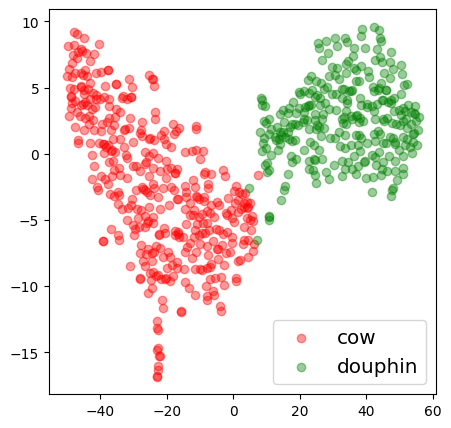

In [70]:
classes = [48, 49] # cow, dophin
concepts = [0, 1, 2] # black, white, blue
# embeddings with cow and dophin
y_cow = np.argwhere(y==48)[:,0]
y_dophin = np.argwhere(y==49)[:,0]
print(y_cow.shape, y_dophin.shape)

# u_cow = u[y_cow,0:3,:]
# u_dophin = u[y_dophin,0:3,:]
z_cow = c_hat[y_cow,0:3,:]
z_dophin = c_hat[y_dophin,0:3,:]
print(z_cow.shape, z_dophin.shape)
n_c, n_d = z_cow.shape[0], z_dophin.shape[0]
z_cow = z_cow.reshape(n_c, -1)
z_dophin = z_dophin.reshape(n_d, -1)
z_all = np.concatenate([z_cow, z_dophin], 0)

X_tsne = TSNE(n_components=2,random_state=33).fit_transform(z_all)
print(X_tsne.shape)
colors = ['r', 'g']
img_dir = "SE-CBM-group"
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.scatter(X_tsne[0:n_c,0], X_tsne[0:n_c,1], c='r', label='cow', alpha=0.4)
plt.scatter(X_tsne[n_c:,0], X_tsne[n_c:,1], c='g', label='douphin', alpha=0.4)
plt.legend(fontsize='x-large')
os.makedirs('visualization/CEM', exist_ok=True)
plt.savefig('visualization/CEM/digits_tsne_Z.pdf')

In [71]:
u_cow = c_hat[y_cow,0:3,:]
u_dophin = c_hat[y_dophin,0:3,:]
n_c, n_d = u_cow.shape[0], u_dophin.shape[0]
print(u_cow.shape)

uc = u_cow.transpose(1,0,2).reshape(-1, 32)
ud = u_dophin.transpose(1,0,2).reshape(-1, 32)
print(uc.shape)
lc = np.array([0,1,2]).repeat(n_c)
ld = np.array([3, 4, 5]).repeat(n_d)
u_emb = np.concatenate([uc, ud], 0)
l_emb = np.concatenate([lc, ld], 0)
print(u_emb, l_emb)
print(u_cow[0,0],  u_cow[1,0])

(392, 3, 32)
(1176, 32)
[[ 3.32092619e+00 -5.39481118e-02 -2.13735960e-02 ...  2.27836561e+00
   1.02952182e+00  2.68664932e+00]
 [ 1.11993885e+00 -1.51908975e-02  1.04457736e-01 ...  7.95226693e-02
  -1.11021325e-02  1.16413486e+00]
 [ 2.94295621e+00 -5.17386124e-02 -2.58500259e-02 ... -3.94878123e-04
   7.54836380e-01  9.97667193e-01]
 ...
 [-1.52557818e-02 -3.21869589e-02 -2.96030426e-03 ...  1.21173525e+00
  -1.87807176e-02 -1.85609292e-02]
 [-2.28864849e-02 -8.65746662e-03  4.77785021e-02 ...  1.12547207e+00
   1.51252067e-02 -8.95506702e-04]
 [-1.88142341e-02 -2.23503504e-02  6.98483270e-03 ...  7.57753432e-01
  -1.54262986e-02 -1.14812516e-02]] [0 0 0 ... 5 5 5]
[ 3.3209262  -0.05394811 -0.0213736  -0.03634704  1.4746578   0.50143576
 -0.00921791  4.3513436  -0.00667029  0.2531055  -0.07813282 -0.02761849
  1.6841204   2.0709498   3.139842   -0.02265416 -0.02652098 -0.00943702
  0.77962965 -0.04705439 -0.00579826 -0.03122253 -0.0208277   4.3964014
  0.67133594  3.8996396   0.298

(2031, 2)
1176 1461
1461 1746
1746 2031


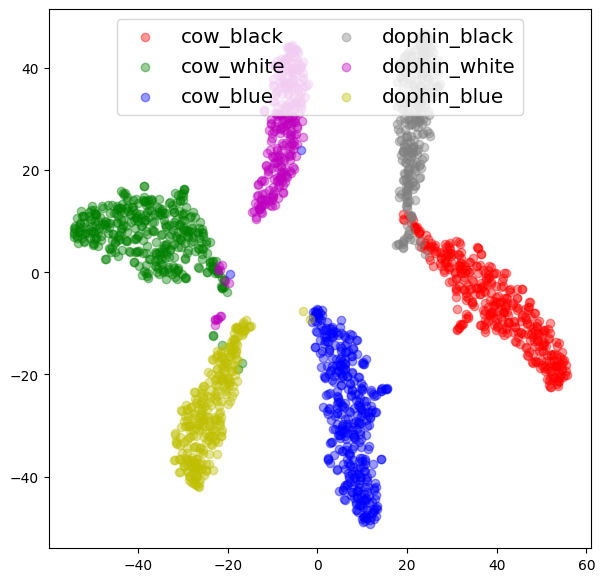

In [72]:
tsne = TSNE(n_components=2, random_state=33)
X_tsne = tsne.fit_transform(u_emb)
print(X_tsne.shape)

colors = ['r', 'g', 'b', 'grey', 'm', 'y']
labels = ['black', 'white', 'blue']
img_dir = "SE-CBM-group"
import matplotlib.pyplot as plt
plt.figure(figsize=[7,7])
#plt.xlim((-60,60))
#plt.ylim((-75,45))

# Sort samples_tsne along the 0th dimension
# samples_tsne_sorted = samples_tsne[np.argsort(samples_tsne[:, 0])]

# Filter points to keep only those between -60 and 60 in the 0th dimension
# samples_tsne_filtered = samples_tsne_sorted[(samples_tsne_sorted[:, 0] >= -60) & (samples_tsne_sorted[:, 0] <= 60)]

# plt.plot(samples_tsne_filtered[:, 0], samples_tsne_filtered[:, 1], c='b', linestyle='-')

# alpha = [0.4, 0.4, 0.25]
for i in range(3):
    plt.scatter(X_tsne[i*n_c: (i+1) * n_c, 0], X_tsne[i*n_c: (i+1) * n_c, 1], c=colors[i], label="cow_" + labels[i], alpha=0.4)
for i in range(3):
    print(3 * n_c + i*n_d, 3* n_c + (i+1) * n_d)
    plt.scatter(X_tsne[3 * n_c + i*n_d: 3* n_c + (i+1) * n_d, 0], X_tsne[3 * n_c + i*n_d: 3* n_c + (i+1) * n_d, 1], c=colors[i+3], label="dophin_" + labels[i], alpha=0.4)
plt.legend(ncol=2, loc='upper center', fontsize='x-large')
plt.savefig('visualization/CEM/digits_tsne_NLP.pdf')